# Baseline inference using 2D-only models
This notebook makes an inference on the validation set of 2D images in KITTI-360 as defined by the official split in `2013_05_28_drive_val_frames.txt`. The validation is performed using the official scripts provided by the dataset authors [here](https://github.com/autonomousvision/kitti360Scripts/tree/master). The models used in the paper are:
- DeepLabV3+ with a ResNet-18 backbone, pretrained on Cityscapes, finetuned for 40k iters on the KITTI-360 dataset using the official split `2013_05_28_drive_train_frames.txt` resulting in average 56.7 mIoU;
- DeepLabV3+ with a ResNet-18 backbone, pretrained on Cityscapes, finetuned for 40k iters on the KITTI-360 dataset using the official split `2013_05_28_drive_train_frames.txt` and an Online Hard Example Mining as defined by [MMSegmentation docs](https://mmsegmentation.readthedocs.io/en/0.x/tutorials/training_tricks.html#online-hard-example-mining-ohem) resulting in average 57.4 mIoU;
- DeepLabV3+ with a ResNet-18 backbone, pretrained on Cityscapes, finetuned for 40k iters on the KITTI-360 dataset using the official split `2013_05_28_drive_train_frames.txt` and class weights resulting in average 59.3 mIoU;
- DeepLabV3+ with a ResNet-101 backbone, pretrained on Cityscapes, finetuned for 40k iters on the KITTI-360 dataset using the official split `2013_05_28_drive_train_frames.txt` resulting in average 62.4 mIoU;

In [1]:
# Since the models output train IDs, their outputs need to be mapped to the label IDs for the official evaluation script to work properly
import sys
sys.path.append("/home/jovyan/DeepViewAgg/dataset/2d/kitti360Scripts")
from kitti360scripts.helpers.labels import trainId2label
import numpy as np
from PIL import Image

def trainId_to_labelId(pred):
    """
    pred : H×W array with values 0-18 or 255
    returns same shape array with Cityscapes/KITTI-360 labelIds
    """
    label_map = np.vectorize(lambda x: trainId2label[x].id, otypes=[np.uint8])
    return label_map(pred)

def labelId_to_trainId(mask):
    """Convert an H×W uint8 label-ID array to train-ID array."""
    out = np.full_like(mask, 255)          # default ignore
    for lid, tid in label2trainId.items():
        if tid != 255:                    # skip void
            out[mask == lid] = tid
    return out

## Finetuned models

Because of mapping issues, the training images are converted to have train IDs instead of label IDs using the script `convert_train_labels.py`. The difference can be seen in the following code cell:

In [2]:
#For a training image
try:
    from PIL import Image
    import numpy as np

    image_path = "/home/jovyan/DeepViewAgg/dataset/2d/data_2d_semantics/train/2013_05_28_drive_0000_sync/image_00/semantic/0000000250.png"
    
    # Open the image
    img = Image.open(image_path)
    img_array = np.array(img.convert('L')) 
    
    # Find unique pixel values
    unique_values = np.unique(img_array)
    
    print(f"Unique pixel values in {image_path}:")
    print(unique_values)
    
    # Check dimensions and data type
    print(f"Image shape: {img_array.shape}")
    print(f"Image data type: {img_array.dtype}")
    
    print("\n Converted:")
    image_path = "/home/jovyan/DeepViewAgg/dataset/2d/data_2d_semantics_trainID/train/2013_05_28_drive_0000_sync/image_00/semantic/0000000250.png"
    img = Image.open(image_path)
    img_array = np.array(img.convert('L')) 
    
    unique_values = np.unique(img_array)
    
    print(f"Unique pixel values in {image_path}:")
    print(unique_values)
    
    print(f"Image shape: {img_array.shape}")
    print(f"Image data type: {img_array.dtype}")

except FileNotFoundError:
    print(f"Error: The file was not found at {image_path}")
    print("Please ensure the path is correct and the file exists where your notebook/script can access it.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Unique pixel values in /home/jovyan/DeepViewAgg/dataset/2d/data_2d_semantics/train/2013_05_28_drive_0000_sync/image_00/semantic/0000000250.png:
[ 6  7  8  9 11 12 13 17 21 22 23 26 38]
Image shape: (376, 1408)
Image data type: uint8

 Converted:
Unique pixel values in /home/jovyan/DeepViewAgg/dataset/2d/data_2d_semantics_trainID/train/2013_05_28_drive_0000_sync/image_00/semantic/0000000250.png:
[  0   1   2   3   4   5   8   9  10  13 255]
Image shape: (376, 1408)
Image data type: uint8


### Fine-tuned model 1
This model was fine-tuned on 40k iters, using `samples_per_gpu = 2` and `GradientCumulativeOptimizerHook` with `cumulative_iter = 4` to compensate for the difference in environments ( 1 A10 GPU vs 4 V100 GPUs used for training). The model makes use of `OHEMPixelSampler` for the decoder head in order to compensate for the rare classes such as traffic sign, traffic light and others. Use this cell to get a stored prediction.

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from mmseg.apis import init_segmentor, inference_segmentor
from kitti360scripts.helpers.labels import trainId2label
trainId_to_labelId = np.vectorize(lambda x: trainId2label[x].id, otypes=[np.uint8])

# model configuration
cfg  = '/path/to/your/config'
ckpt = '/path/to/your/checkpoint'
model = init_segmentor(cfg, ckpt, device='cuda:0')
EVAL_LABELS = {7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28,31,32,33}

# paths
prefix     = '/home/jovyan/DeepViewAgg/dataset/2d'
val_txt    = f'{prefix}/2013_05_28_drive_val_frames.txt'
out_dir    = f'{prefix}/predictions_2d_mm_finetune'
os.makedirs(out_dir, exist_ok=True)

with open(val_txt) as f:
    samples = [line.strip().split() for line in f]      # img_rel, gt_rel

# inference loop
with torch.no_grad():
    for img_rel, gt_rel in tqdm(samples):
        img_path   = os.path.join(prefix, img_rel)
        label_path = os.path.join(prefix, gt_rel)

        # 1. predict in trainId space
        pred = inference_segmentor(model, img_path)[0].astype(np.uint8)

        # 2. convert to labelId
        pred = trainId_to_labelId(pred)

        # 3. copy void mask from GT  (keep ignore == 0) not needed but still left, because of no negative effect
        gt_img = np.array(Image.open(label_path))
        void_mask = ~np.isin(gt_img, list(EVAL_LABELS))
        pred[void_mask] = 0

        # 4. save as raw 8-bit PNG  (“L” mode)
        parts     = gt_rel.split('/')
        drive_dir = parts[2]                  # “2013_05_28_drive_0003_sync”
        seq        = int(drive_dir.split('_')[4])
        frame_str = parts[-1].split('.')[0]   # “0000000123”
        name       = f"{seq:04d}_{int(frame_str):010d}.png"
        save_path = os.path.join(out_dir, os.path.basename(name))
        Image.fromarray(pred, mode='L').save(save_path)


This cell can be used to produce visualization for your predictions

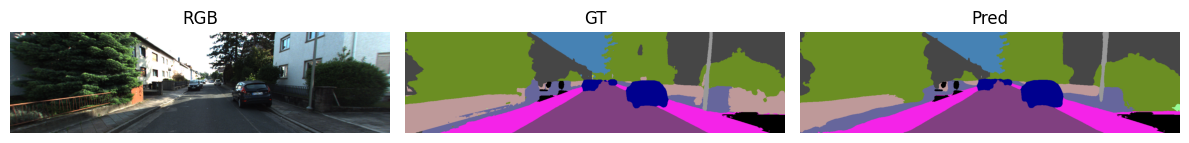

GT  trainIds : [ 0  1  2  3  4  5  7  8  9 10 13]
Pred trainIds: [  0   1   2   3   4   5   8   9  10  13 255] 



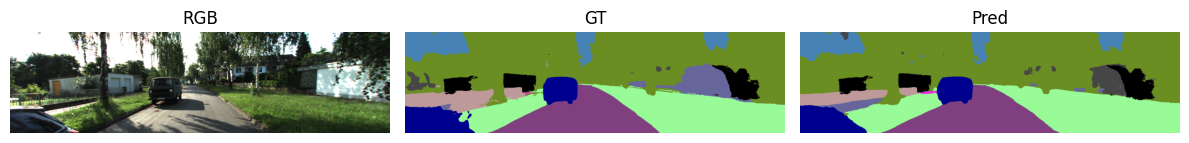

GT  trainIds : [ 0  1  2  3  4  5  8  9 10 13]
Pred trainIds: [  0   1   2   3   4   8   9  10  13 255] 



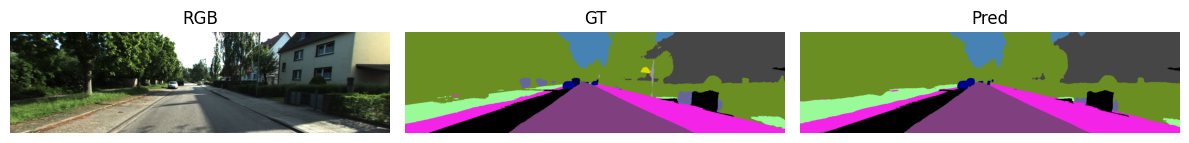

GT  trainIds : [ 0  1  2  3  4  5  7  8  9 10 13 14]
Pred trainIds: [  0   1   2   3   8   9  10  13 255] 



In [18]:
# Method to build the KITTI-360 palette and make vizualization of 3 prediction images
import numpy as np, imageio.v2 as imageio, matplotlib.pyplot as plt
from pathlib import Path
from kitti360scripts.helpers.labels import trainId2label

palette = np.zeros((256, 3), dtype=np.uint8)
for tid, lbl in trainId2label.items():
    if 0 <= lbl.id < 256:        
        palette[lbl.id] = lbl.color
palette_flat = palette.flatten()   

label2train = {lbl.id: tid for tid, lbl in trainId2label.items()}


root      = Path('/home/jovyan/DeepViewAgg/dataset/2d')
pred_root = root / 'predictions_2d_mm_finetune'                    # label-ID preds
val_txt   = root / '2013_05_28_drive_val_frames.txt'
lines     = open(val_txt).read().splitlines()


for idx in [0, 100, 300]:

    img_rel, gt_rel = lines[idx].split()
    gt_elem = gt_rel.split("/")
    drive_dir = gt_elem[2]                  # “2013_05_28_drive_0003_sync”
    seq = int(drive_dir.split('_')[4])
    frame_str = gt_elem[-1].split('.')[0]   # “0000000123”
    name = f"{seq:04d}_{int(frame_str):010d}.png"

    rgb   = imageio.imread(root / img_rel)                # RGB frame
    gt    = imageio.imread(root / gt_rel)                 # label-ID GT
    pred  = imageio.imread(pred_root / name) # label-ID pred

    # quick sanity arrays (train-ID sets)
    gt_tids   = np.unique([label2train[l] for l in np.unique(gt) if l in label2train])
    pred_tids = np.unique([label2train[l] for l in np.unique(pred) if l in label2train])

    def colourise(mask):
        return palette[mask]           # H×W×3 uint8

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title('RGB');  plt.imshow(rgb);              plt.axis('off')
    plt.subplot(1, 3, 2); plt.title('GT');   plt.imshow(colourise(gt));    plt.axis('off')
    plt.subplot(1, 3, 3); plt.title('Pred'); plt.imshow(colourise(pred));  plt.axis('off')
    plt.tight_layout(); plt.show()


## Computing weights for classes
In this section the weights for the different classes are computed based on the training images and the pixels present in them according to the different classes. The model is trained using the converted data with train IDs, so the histograms and weights are also computed with the train IDs converted images.

In [50]:
import os, glob, numpy as np, imageio.v2 as imageio
from tqdm import tqdm

prefix   = '/home/jovyan/DeepViewAgg/dataset/2d'
val_txt  = f'{prefix}/2013_05_28_drive_val_frames.txt'

# Build a set of validation mask paths (relative to 'prefix')
val_masks = set()
with open(val_txt) as f:
    for line in f:
        _, gt_rel = line.strip().split()     # txt lines: <img path> <ground truth path>
        val_masks.add(os.path.normpath(gt_rel))   # e.g. data_2d_semantics/...

# Scan every TrainID mask in the folder, exclude val masks
pattern = f'{prefix}/data_2d_semantics_trainID/train/*/image_00/semantic/*.png'
hist = np.zeros(19, dtype=np.int64)

for fn in tqdm(glob.glob(pattern, recursive=True)):
    # convert absolute path to relative to prefix, same style as in the validation txt file
    rel = os.path.relpath(fn, prefix).replace('_trainID', '')
    if rel in val_masks:
        continue   # skip validation frame

    mask = imageio.imread(fn)
    mask = mask[mask != 255]           # drop ignore pixels
    if mask.size:
        hist += np.bincount(mask, minlength=19)[:19]

pixels = hist.sum()
assert pixels > 0, 'No training pixels counted – check paths!'

freq   = hist / pixels
median = np.median(freq[freq > 0])
weights = median / np.clip(freq, 1e-6, None)      # median/freq

print('class_weight =', list(np.round(weights, 4)))


100%|██████████| 61280/61280 [07:17<00:00, 140.21it/s] 

class_weight = [0.0331, 0.0783, 0.027, 0.1806, 0.2285, 1.3831, 447.6775, 3.993, 0.0139, 0.1604, 0.0653, 11.1411, 16.6062, 0.0842, 1.0, 26.0818, 21.0888, 18.598, 44.731]


In [51]:
# Look into the count of the pixels to better interpret the weights

classes = ['road','sidewalk','building','wall','fence','pole',
           't-light','t-sign','veget','terrain','sky',
           'person','rider','car','truck','bus','train','moto','bike']
for i,c in enumerate(classes):
    print(f'{c:<8s}: {hist[i]:>9d} px')

road    : 3847821703 px
sidewalk: 1625859442 px
building: 4709628956 px
wall    : 705200481 px
fence   : 557180267 px
pole    :  92066175 px
t-light :    284443 px
t-sign  :  31890848 px
veget   : 9157482308 px
terrain : 793884111 px
sky     : 1949343354 px
person  :  11429680 px
rider   :   7668140 px
car     : 1511975729 px
truck   : 127338736 px
bus     :   4882282 px
train   :   6038208 px
moto    :   6846920 px
bike    :   2846768 px


Since some weights are quite large, because of a really small number of pixels present, ENet's class weighting approach is adopted with the following formula:<br>
$w_{i} = \frac{1}{log(1 + D_{i})}$, where $D_{i}$ is the number of pixels, and $w_{i}$ the weight for class i

In [55]:
import numpy as np, math, pprint

D = np.array([
    3847821703, 1625859442, 4709628956, 705200481, 557180267,  92066175,
      284443,    31890848, 9157482308, 793884111, 1949343354,  11429680,
     7668140,  1511975729, 127338736,   4882282,    6038208,    6846920,
     2846768], dtype=np.float64)

w = 1.0 / np.log1p(D)         # inverse log
w = 19 * w / w.sum()          # mean(w) == 1

pprint.pprint(np.round(w, 3).tolist())

[0.818,
 0.851,
 0.81,
 0.886,
 0.896,
 0.984,
 1.437,
 1.045,
 0.787,
 0.881,
 0.844,
 1.111,
 1.139,
 0.854,
 0.967,
 1.172,
 1.156,
 1.147,
 1.215]


### Getting results for other models
If you want to make predictions for other models, just reuse the cell for predicting above, but adjust the config, checkpoint, and output directory. If you want to validate your predictions, check the README.md for more details on how to.